## Natural Language Processing

## Import Modules & Global Variable Definition

In [1]:
!pip install -U -q PyDrive

In [2]:
%matplotlib inline

import os
import os.path
import io
import re
from collections import defaultdict
import nltk
from nltk.tokenize import TreebankWordTokenizer

# Core
import pandas as pd
import numpy as np
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Data
import json
from collections import defaultdict

# Visuals
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Text
import re  # regular expressions

# Url
import urllib.parse

# Display Images
from PIL import Image, ImageFilter

# IPython display
from IPython.display import display

# Loading Zip Files
import zipfile

# Working with images
import cv2

# Progress Bar (for long processes)
from tqdm import tqdm

In [3]:
!pip install -U -q chakin

In [4]:
import tensorflow as tf
import time
import chakin

In [5]:
# Lists available chakin indices in English
chakin.search(lang='English')

                   Name  Dimension                     Corpus VocabularySize  \
2          fastText(en)        300                  Wikipedia           2.5M   
11         GloVe.6B.50d         50  Wikipedia+Gigaword 5 (6B)           400K   
12        GloVe.6B.100d        100  Wikipedia+Gigaword 5 (6B)           400K   
13        GloVe.6B.200d        200  Wikipedia+Gigaword 5 (6B)           400K   
14        GloVe.6B.300d        300  Wikipedia+Gigaword 5 (6B)           400K   
15       GloVe.42B.300d        300          Common Crawl(42B)           1.9M   
16      GloVe.840B.300d        300         Common Crawl(840B)           2.2M   
17    GloVe.Twitter.25d         25               Twitter(27B)           1.2M   
18    GloVe.Twitter.50d         50               Twitter(27B)           1.2M   
19   GloVe.Twitter.100d        100               Twitter(27B)           1.2M   
20   GloVe.Twitter.200d        200               Twitter(27B)           1.2M   
21  word2vec.GoogleNews        300      

In [6]:
RANDOM_SEED = 9999

CHAKIN_INDEX = 11
NUMBER_OF_DIMENSIONS = 50
SUBFOLDER_NAME = 'gloVe.6B'

EMBEDDINGS_DIRECTORY = '/Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/embeddings/gloVe.6B/'
FILENAME_50 = 'glove.6B.50d.txt'
FILENAME_100 = 'glove.6B.100d.txt'
EMBEDDINGS_FILENAME_50 = os.path.join(EMBEDDINGS_DIRECTORY, FILENAME_50)
EMBEDDINGS_FILENAME_100 = os.path.join(EMBEDDINGS_DIRECTORY, FILENAME_100)

MOVIE_REVIEWS = '/Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/'
MOVIE_REVIEWS_POS = 'movie-reviews-positive'
MOVIE_REVIEWS_NEG = 'movie-reviews-negative'

In [7]:
# No stopword removal
REMOVE_STOPWORDS = False

In [8]:
# Specify desired size of pre-defined embedding vocabulary
EVOCABSIZE = 10000

In [9]:
# To make output stable across runs
def reset_graph(seed=RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## glove.6B.50d.txt

In [20]:
# Utility function for loading embeddings follows methods described in
# https://github.com/guillaume-chevalier/GloVe-as-a-TensorFlow-Embedding-Layer
# Creates the Python defaultdict dictionary word_to_embedding_dict
# for the requested pre-trained word embeddings
# 
# Note the use of defaultdict data structure from the Python Standard Library
# collections_defaultdict.py lets the caller specify a default value up front
# The default value will be retuned if the key is not a known dictionary key
# That is, unknown words are represented by a vector of zeros
# For word embeddings, this default value is a vector of zeros
# Documentation for the Python standard library:

def load_embedding_from_disks(embeddings_filename, with_indexes=True):
    """
    Read a embeddings txt file. If `with_indexes=True`, 
    we return a tuple of two dictionnaries
    `(word_to_index_dict, index_to_embedding_array)`, 
    otherwise we return only a direct 
    `word_to_embedding_dict` dictionnary mapping 
    from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
  
    else:
        word_to_embedding_dict = dict()

    with open(embeddings_filename, 'r', encoding='utf-8') as embeddings_file:
        for (i, line) in enumerate(embeddings_file):

            split = line.split(' ')

            word = split[0]

            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )

            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    # Empty representation for unknown words.
    _WORD_NOT_FOUND = [0.0] * len(representation)
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(
            lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(
            index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict

In [21]:
# Select the pre-defined embeddings source        
# Define vocabulary size for the language model    
# Create a word_to_embedding_dict for GloVe.6B.50d

print('\nLoading embeddings from', EMBEDDINGS_FILENAME_50)
word_to_index, index_to_embedding = \
    load_embedding_from_disks(EMBEDDINGS_FILENAME_50, with_indexes=True)
print("Embedding loaded from disks.")


Loading embeddings from /Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/embeddings/gloVe.6B/glove.6B.50d.txt
Embedding loaded from disks.


In [22]:
# Additional background code from
# https://github.com/guillaume-chevalier/GloVe-as-a-TensorFlow-Embedding-Layer
# shows the general structure of the data structures for word embeddings
# This code is modified for our purposes in language modeling 
vocab_size, embedding_dim = index_to_embedding.shape
print("Embedding is of shape: {}".format(index_to_embedding.shape))
print("This means (number of words, number of dimensions per word)\n")
print("The first words are words that tend occur more often.")

print("Note: for unknown words, the representation is an empty vector,\n"
      "and the index is the last one. The dictionnary has a limit:")
print("    {} --> {} --> {}".format("A word", "Index in embedding", 
      "Representation"))
word = "worsdfkljsdf"  # a word obviously not in the vocabulary
idx = word_to_index[word] # index for word obviously not in the vocabulary
complete_vocabulary_size = idx 
embd = list(np.array(index_to_embedding[idx], dtype=int)) # "int" compact print
print("    {} --> {} --> {}".format(word, idx, embd))
word = "the"
idx = word_to_index[word]
embd = list(index_to_embedding[idx])  # "int" for compact print only.
print("    {} --> {} --> {}".format(word, idx, embd))

Embedding is of shape: (400001, 50)
This means (number of words, number of dimensions per word)

The first words are words that tend occur more often.
Note: for unknown words, the representation is an empty vector,
and the index is the last one. The dictionnary has a limit:
    A word --> Index in embedding --> Representation
    worsdfkljsdf --> 400000 --> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    the --> 0 --> [0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0.044457, -0.49688, -0.17862, -0.00066023, -0.6566, 0.27843, -0.14767, -0.55677, 0.14658, -0.0095095, 0.011658, 0.10204, -0.12792, -0.8443, -0.12181, -0.016801, -0.33279, -0.1552, -0.23131, -0.19181, -1.8823, -0.76746, 0.099051, -0.42125, -0.19526, 4.0071, -0.18594, -0.52287, -0.31681, 0.00059213, 0.0074449, 0.17778, -0.15897, 0.012041, -0.054223, -0.29871, -0.15749, -0.34758, -0.045637, -0.44251, 0.18785, 0.0027849, -0.18

In [23]:
# Show how to use embeddings dictionaries with a test sentence
# This is a famous typing exercise with all letters of the alphabet
# https://en.wikipedia.org/wiki/The_quick_brown_fox_jumps_over_the_lazy_dog
a_typing_test_sentence = 'The quick brown fox jumps over the lazy dog'
print('\nTest sentence: ', a_typing_test_sentence, '\n')
words_in_test_sentence = a_typing_test_sentence.split()

print('Test sentence embeddings from complete vocabulary of', 
      complete_vocabulary_size, 'words:\n')
for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = index_to_embedding[word_to_index[word_]]
    print(word_ + ": ", embedding)


Test sentence:  The quick brown fox jumps over the lazy dog 

Test sentence embeddings from complete vocabulary of 400000 words:

the:  [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
quick:  [ 0.13967   -0.53798   -0.18047   -0.25142    0.16203   -0.13868
 -0.24637    0.75111    0.27264    0.61035   -0.82548    0.038647
 -0.32361    0.30373   -0.14598   -0.23551    0.39267   -1.1287
 -0.23636   -1.0629     0.046277   0.29143   -0.25

In [24]:
# Define vocabulary size for the language model    
# To reduce the size of the vocabulary to the n most frequently used words

def default_factory():
    return EVOCABSIZE  # last/unknown-word row in limited_index_to_embedding
# dictionary has the items() function, returns list of (key, value) tuples
limited_word_to_index = defaultdict(default_factory, \
    {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})

In [25]:
# Select the first EVOCABSIZE rows to the index_to_embedding
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]
# Set the unknown-word row to be all zeros as previously
limited_index_to_embedding = np.append(limited_index_to_embedding, 
    index_to_embedding[index_to_embedding.shape[0] - 1, :].\
        reshape(1,embedding_dim), 
    axis = 0)

In [26]:
# Delete large numpy array to clear some CPU RAM
del index_to_embedding

In [27]:
# Verify the new vocabulary: should get same embeddings for test sentence
# Note that a small EVOCABSIZE may yield some zero vectors for embeddings
print('\nTest sentence embeddings from vocabulary of', EVOCABSIZE, 'words:\n')
for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = limited_index_to_embedding[limited_word_to_index[word_]]
    print(word_ + ": ", embedding)


Test sentence embeddings from vocabulary of 10000 words:

the:  [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
quick:  [ 0.13967   -0.53798   -0.18047   -0.25142    0.16203   -0.13868
 -0.24637    0.75111    0.27264    0.61035   -0.82548    0.038647
 -0.32361    0.30373   -0.14598   -0.23551    0.39267   -1.1287
 -0.23636   -1.0629     0.046277   0.29143   -0.25819   -0.094902
  0.79478   -1.2095    -0.01039   -0.092086   0.84322   

## Movie Review Data

In [28]:
# code for working with movie reviews data 
# Source: Miller, T. W. (2016). Web and Network Data Science.
#    Upper Saddle River, N.J.: Pearson Education.
#    ISBN-13: 978-0-13-388644-3
# This original study used a simple bag-of-words approach
# to sentiment analysis, along with pre-defined lists of
# negative and positive words.        
# Code available at:  https://github.com/mtpa/wnds       
# ------------------------------------------------------------
# Utility function to get file names within a directory
def listdir_no_hidden(path):
    start_list = os.listdir(path)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file)
    return(end_list)

In [29]:
# define list of codes to be dropped from document
# carriage-returns, line-feeds, tabs
codelist = ['\r', '\n', '\t']   

In [30]:
# We will not remove stopwords in this exercise because they are
# important to keeping sentences intact
if REMOVE_STOPWORDS:
    print(nltk.corpus.stopwords.words('english'))

In [31]:
# previous analysis of a list of top terms showed a number of words, along 
# with contractions and other word strings to drop from further analysis, add
# these to the usual English stopwords to be dropped from a document collection
more_stop_words = ['cant','didnt','doesnt','dont','goes','isnt','hes',\
    'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
    've', 're', 'vs'] 

some_proper_nouns_to_remove = ['dick','ginger','hollywood','jack',\
    'jill','john','karloff','kudrow','orson','peter','tcm','tom',\
    'toni','welles','william','wolheim','nikita']

# start with the initial list and add to it for movie text work 
stoplist = nltk.corpus.stopwords.words('english') + more_stop_words +\
    some_proper_nouns_to_remove

In [32]:
# text parsing function for creating text documents 
# there is more we could do for data preparation 
# stemming... looking for contractions... possessives... 
# but we will work with what we have in this parsing function
# if we want to do stemming at a later time, we can use
#     porter = nltk.PorterStemmer()  
# in a construction like this
#     words_stemmed =  [porter.stem(word) for word in initial_words]  
def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z]', '  ', string)    
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = ' ' + codelist[i] + '  '
        temp_string = re.sub(stopstring, '  ', temp_string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()    
    if REMOVE_STOPWORDS:
        # replace selected character strings/stop-words with space
        for i in range(len(stoplist)):
            stopstring = ' ' + str(stoplist[i]) + ' '
            temp_string = re.sub(stopstring, ' ', temp_string)        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string) 

In [33]:
# gather data for 500 negative movie reviews
dir_name = '/Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-negative'

filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

In [34]:
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))


Directory: /Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-negative
500 files found


In [35]:
# Read data for negative movie reviews
# Data will be stored in a list of lists where the each list represents 
# a document and document is a list of words.
# We then break the text into words.

def read_data(filename):

  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

negative_documents = []

In [36]:
print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    negative_documents.append(words)
    # print('Data size (Characters) (Document %d) %d' %(i,len(words)))
    # print('Sample string (Document %d) %s'%(i,words[:50]))


Processing document files under /Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-negative


In [37]:
# gather data for 500 positive movie reviews
dir_name = '/Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-positive'  
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

In [38]:
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))


Directory: /Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-positive
500 files found


In [39]:
# Read data for positive movie reviews
# Data will be stored in a list of lists where the each list 
# represents a document and document is a list of words.
# We then break the text into words.

def read_data(filename):

  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

positive_documents = []

In [40]:
print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    positive_documents.append(words)
    # print('Data size (Characters) (Document %d) %d' %(i,len(words)))
    # print('Sample string (Document %d) %s'%(i,words[:50]))


Processing document files under /Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-positive


In [41]:
# convert positive/negative documents into numpy array
# note that reviews vary from 22 to 1052 words   
# so we use the first 20 and last 20 words of each review 
# as our word sequences for analysis
max_review_length = 0  # initialize
for doc in negative_documents:
    max_review_length = max(max_review_length, len(doc))    
for doc in positive_documents:
    max_review_length = max(max_review_length, len(doc)) 
print('max_review_length:', max_review_length) 

min_review_length = max_review_length  # initialize
for doc in negative_documents:
    min_review_length = min(min_review_length, len(doc))    
for doc in positive_documents:
    min_review_length = min(min_review_length, len(doc)) 
print('min_review_length:', min_review_length) 

max_review_length: 1052
min_review_length: 22


In [42]:
# construct list of 1000 lists with 40 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end]))) 

In [43]:
# create list of lists of lists for embeddings
embeddings = []    
for doc in documents:
    embedding = []
    for word in doc:
       embedding.append(limited_index_to_embedding[limited_word_to_index[word]]) 
    embeddings.append(embedding)

In [44]:
# Check on the embeddings list of list of lists 
# Show the first word in the first document
test_word = documents[0][0]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[0][0][:])

First word in first document: while
Embedding for this word:
 [ 0.1011   -0.16566   0.22035  -0.10629   0.46929   0.37968  -0.62815
 -0.14385  -0.38333   0.055405  0.23511  -0.20999  -0.55395  -0.38271
  0.21008   0.02161  -0.23054  -0.13576  -0.61636  -0.4678    0.25716
  0.62309   0.3837   -0.25665   0.09041  -1.5184    0.4762   -0.089573
  0.025347 -0.25974   3.6121    0.62788   0.15387  -0.062747  0.28699
 -0.16471  -0.2079    0.4407    0.065441 -0.10303  -0.15489   0.27352
  0.38356  -0.098016  0.10705  -0.083071 -0.27168  -0.49441   0.043538
 -0.39141 ]
Corresponding embedding from embeddings list of list of lists
 [ 0.1011   -0.16566   0.22035  -0.10629   0.46929   0.37968  -0.62815
 -0.14385  -0.38333   0.055405  0.23511  -0.20999  -0.55395  -0.38271
  0.21008   0.02161  -0.23054  -0.13576  -0.61636  -0.4678    0.25716
  0.62309   0.3837   -0.25665   0.09041  -1.5184    0.4762   -0.089573
  0.025347 -0.25974   3.6121    0.62788   0.15387  -0.062747  0.28699
 -0.16471  -0.2079  

In [45]:
# Show the seventh word in the tenth document
test_word = documents[6][9]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[6][9][:])

First word in first document: officially
Embedding for this word:
 [ 0.13682  -0.10324  -0.10126  -0.13996   0.080166 -0.18858  -0.96708
 -0.066722 -0.254    -0.61085   0.88298  -0.23186  -0.09482  -0.22099
  0.85226   0.47223  -0.73086   0.054607 -0.22859   0.6526    0.05519
 -0.47021   0.35769   0.18049  -0.23699  -1.3029    0.14341   0.044548
 -0.70229   0.022042  2.3984   -0.46118  -0.88351  -0.5511   -0.25662
 -0.56969   1.1733   -0.077844 -0.96175  -0.30038  -0.58143  -0.8909
 -0.34433  -0.53421  -0.84671   0.03971  -1.0485   -0.12547  -0.072426
 -0.19364 ]
Corresponding embedding from embeddings list of list of lists
 [ 0.13682  -0.10324  -0.10126  -0.13996   0.080166 -0.18858  -0.96708
 -0.066722 -0.254    -0.61085   0.88298  -0.23186  -0.09482  -0.22099
  0.85226   0.47223  -0.73086   0.054607 -0.22859   0.6526    0.05519
 -0.47021   0.35769   0.18049  -0.23699  -1.3029    0.14341   0.044548
 -0.70229   0.022042  2.3984   -0.46118  -0.88351  -0.5511   -0.25662
 -0.56969   1.17

In [46]:
# Show the last word in the last document
test_word = documents[999][39]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[999][39][:])

First word in first document: super
Embedding for this word:
 [-0.59147    0.16468    0.18271    1.4054    -0.23347   -0.2986
 -0.34696   -0.30997   -0.089015  -0.019025   0.28963    0.46779
 -0.85615    0.68968    0.52189    0.24809   -0.022432   1.009
 -2.2903    -0.33961   -0.83609   -0.75197    0.34107    0.31885
 -0.78405   -1.2021    -0.83693   -0.28469    0.41393    0.0074962
  1.7202     1.2959    -0.61426    0.4721     0.71448    0.55194
  0.43352    0.35058   -1.0558    -1.2248    -0.14596    0.11694
 -0.39677    0.13791   -0.03571    1.305     -0.14112   -0.18244
  0.22988    0.39888  ]
Corresponding embedding from embeddings list of list of lists
 [-0.59147    0.16468    0.18271    1.4054    -0.23347   -0.2986
 -0.34696   -0.30997   -0.089015  -0.019025   0.28963    0.46779
 -0.85615    0.68968    0.52189    0.24809   -0.022432   1.009
 -2.2903    -0.33961   -0.83609   -0.75197    0.34107    0.31885
 -0.78405   -1.2021    -0.83693   -0.28469    0.41393    0.0074962
  1.7202

In [47]:
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
embeddings_array = np.array(embeddings)

In [48]:
# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

In [49]:
# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

In [50]:
# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

## Recurrent Neural Network 1

In [51]:
# We use a very simple Recurrent Neural Network for this assignment
# Recurrent Neural Network 1
reset_graph()

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 50
batch_size = 100

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [52]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        print('\n  ---- Epoch ', epoch, ' ----\n')
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            print('  Batch ', iteration, ' training observations from ',  
                  iteration*batch_size, ' to ', (iteration + 1)*batch_size-1,)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print('\n  Train accuracy:', acc_train, 'Test accuracy:', acc_test)


  ---- Epoch  0  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799

  Train accuracy: 0.5 Test accuracy: 0.51

  ---- Epoch  1  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799

  Train accuracy: 0.5 Test accuracy: 0.445

  ---- Epoch  2  ----



  Train accuracy: 0.78 Test accuracy: 0.655

  ---- Epoch  17  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799

  Train accuracy: 0.79 Test accuracy: 0.65

  ---- Epoch  18  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799

  Train accuracy: 

  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799

  Train accuracy: 0.85 Test accuracy: 0.655

  ---- Epoch  35  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799

  Train accuracy: 0.85 Test accuracy: 0.66

  ---- Epoch  36  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  trainin

In [53]:
results = {}

batch_results_raw = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            
            batch_results_raw.append( 'Batch {} training observations from {} to '.format( iteration, iteration*batch_size, (iteration + 1)*batch_size-1))

            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        results[epoch] = {'Train' : acc_train, 'Test' : acc_test}

In [54]:
results_df = pd.DataFrame.from_dict(results)

In [55]:
results_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Test,0.51,0.445,0.495,0.50,0.495,0.515,0.53,0.55,0.575,0.585,...,0.66,0.665,0.655,0.65,0.65,0.65,0.645,0.67,0.675,0.675
Train,0.50,0.500,0.500,0.53,0.560,0.560,0.59,0.61,0.650,0.680,...,0.86,0.860,0.860,0.86,0.86,0.87,0.880,0.87,0.860,0.860


/Users/derekhigham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  after removing the cwd from sys.path.


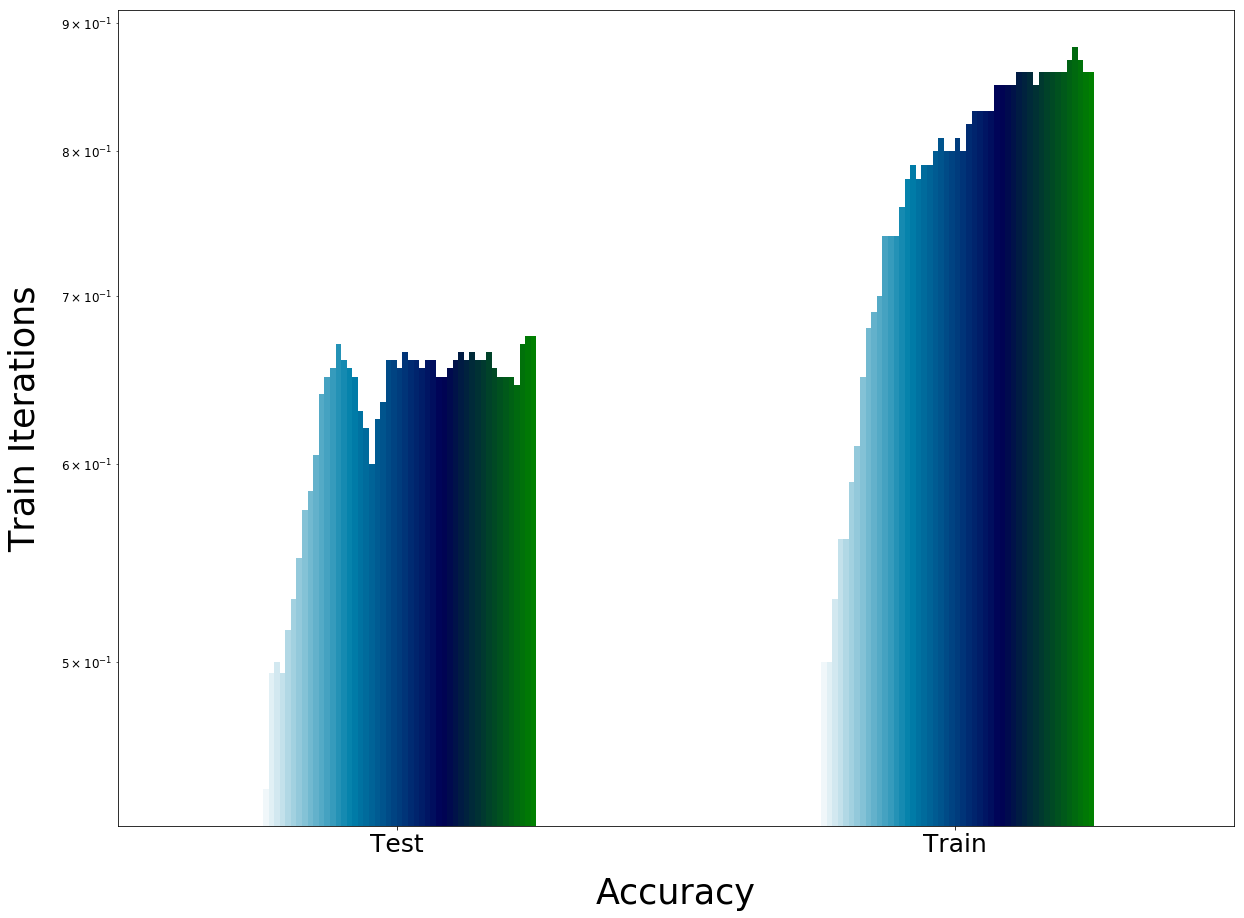

In [56]:
fig, ax = plt.subplots()
fig.patch.set_alpha(0.5)
results_df.plot(kind='bar', legend = False, figsize=(20,15), logy=True, colormap='ocean_r', ax = ax)
ax.set_axis_bgcolor('none')
ax.patch.set_alpha(0.6)

ax.set_xlabel( 'Accuracy', rotation=0, fontsize=35, labelpad=20)
ax.set_ylabel( 'Train Iterations', rotation=90, fontsize=35, labelpad=20)

for label in ax.get_xticklabels():
  label.set_rotation(0)
  label.set_size(25)
        
plt.show()

## Recurrent Neural Network 2

In [58]:
# Recurrent Neural Network 2
reset_graph()

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.002

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 25
batch_size = 50

In [59]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        print('\n  ---- Epoch ', epoch, ' ----\n')
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            print('  Batch ', iteration, ' training observations from ',  
                  iteration*batch_size, ' to ', (iteration + 1)*batch_size-1,)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print('\n  Train accuracy:', acc_train, 'Test accuracy:', acc_test)


  ---- Epoch  0  ----

  Batch  0  training observations from  0  to  49
  Batch  1  training observations from  50  to  99
  Batch  2  training observations from  100  to  149
  Batch  3  training observations from  150  to  199
  Batch  4  training observations from  200  to  249
  Batch  5  training observations from  250  to  299
  Batch  6  training observations from  300  to  349
  Batch  7  training observations from  350  to  399
  Batch  8  training observations from  400  to  449
  Batch  9  training observations from  450  to  499
  Batch  10  training observations from  500  to  549
  Batch  11  training observations from  550  to  599
  Batch  12  training observations from  600  to  649
  Batch  13  training observations from  650  to  699
  Batch  14  training observations from  700  to  749
  Batch  15  training observations from  750  to  799

  Train accuracy: 0.5 Test accuracy: 0.5

  ---- Epoch  1  ----

  Batch  0  training observations from  0  to  49
  Batch  1 

  Batch  1  training observations from  50  to  99
  Batch  2  training observations from  100  to  149
  Batch  3  training observations from  150  to  199
  Batch  4  training observations from  200  to  249
  Batch  5  training observations from  250  to  299
  Batch  6  training observations from  300  to  349
  Batch  7  training observations from  350  to  399
  Batch  8  training observations from  400  to  449
  Batch  9  training observations from  450  to  499
  Batch  10  training observations from  500  to  549
  Batch  11  training observations from  550  to  599
  Batch  12  training observations from  600  to  649
  Batch  13  training observations from  650  to  699
  Batch  14  training observations from  700  to  749
  Batch  15  training observations from  750  to  799

  Train accuracy: 0.8 Test accuracy: 0.6

  ---- Epoch  10  ----

  Batch  0  training observations from  0  to  49
  Batch  1  training observations from  50  to  99
  Batch  2  training observations


  Train accuracy: 0.86 Test accuracy: 0.635

  ---- Epoch  19  ----

  Batch  0  training observations from  0  to  49
  Batch  1  training observations from  50  to  99
  Batch  2  training observations from  100  to  149
  Batch  3  training observations from  150  to  199
  Batch  4  training observations from  200  to  249
  Batch  5  training observations from  250  to  299
  Batch  6  training observations from  300  to  349
  Batch  7  training observations from  350  to  399
  Batch  8  training observations from  400  to  449
  Batch  9  training observations from  450  to  499
  Batch  10  training observations from  500  to  549
  Batch  11  training observations from  550  to  599
  Batch  12  training observations from  600  to  649
  Batch  13  training observations from  650  to  699
  Batch  14  training observations from  700  to  749
  Batch  15  training observations from  750  to  799

  Train accuracy: 0.86 Test accuracy: 0.65

  ---- Epoch  20  ----

  Batch  0  

In [60]:
results = {}

batch_results_raw = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            
            batch_results_raw.append( 'Batch {} training observations from {} to '.format( iteration, iteration*batch_size, (iteration + 1)*batch_size-1))

            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        results[epoch] = {'Train' : acc_train, 'Test' : acc_test}

In [61]:
results_df = pd.DataFrame.from_dict(results)

In [62]:
results_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Test,0.5,0.495,0.595,0.615,0.645,0.645,0.615,0.61,0.605,0.6,...,0.635,0.645,0.635,0.635,0.65,0.645,0.64,0.645,0.655,0.655
Train,0.5,0.500,0.600,0.660,0.740,0.740,0.800,0.80,0.780,0.8,...,0.860,0.880,0.860,0.860,0.86,0.860,0.84,0.840,0.840,0.860


/Users/derekhigham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  after removing the cwd from sys.path.


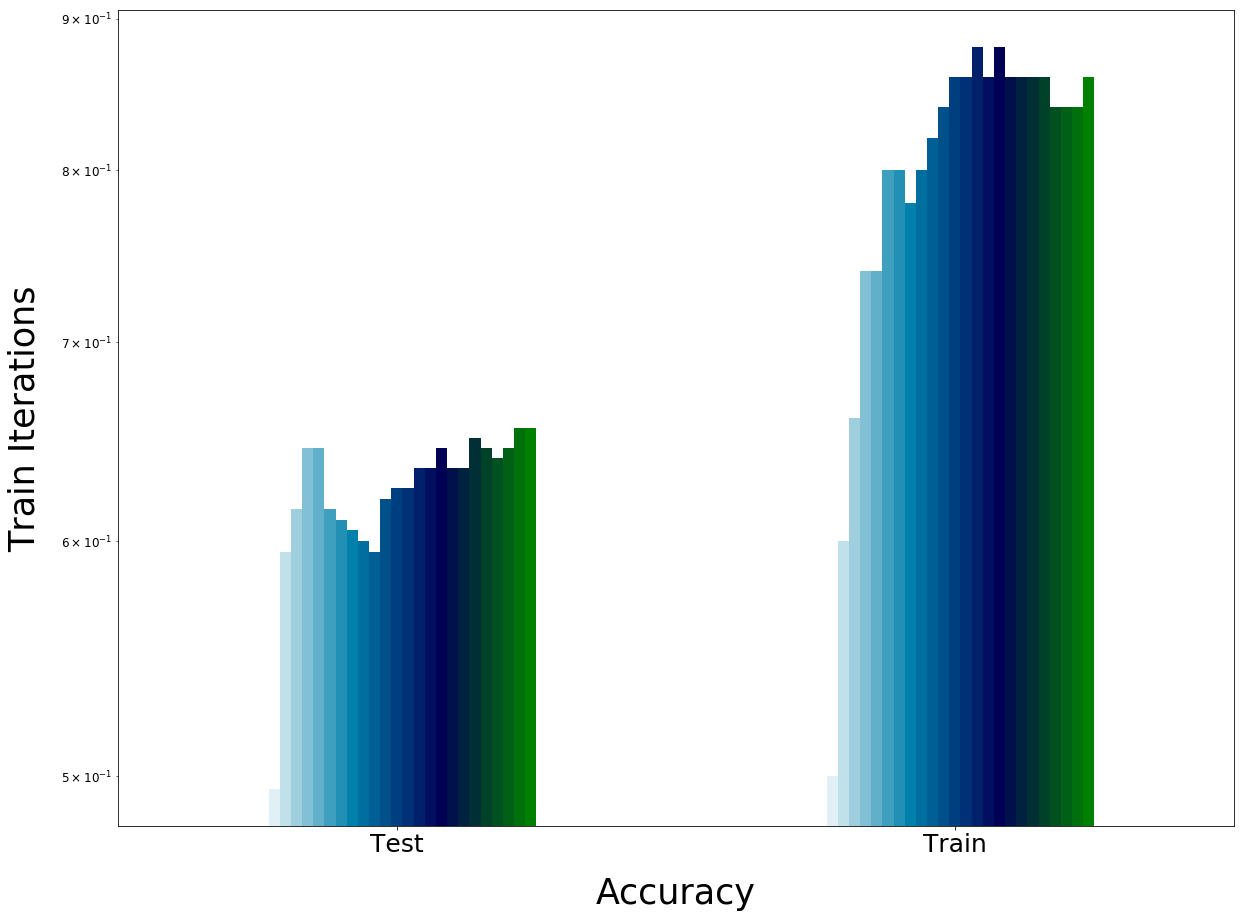

In [63]:
fig, ax = plt.subplots()
fig.patch.set_alpha(0.5)
results_df.plot(kind='bar', legend = False, figsize=(20,15), logy=True, colormap='ocean_r', ax = ax)
ax.set_axis_bgcolor('none')
ax.patch.set_alpha(0.6)

ax.set_xlabel( 'Accuracy', rotation=0, fontsize=35, labelpad=20)
ax.set_ylabel( 'Train Iterations', rotation=90, fontsize=35, labelpad=20)

for label in ax.get_xticklabels():
  label.set_rotation(0)
  label.set_size(25)
        
plt.show()

## glove.6B.100d.txt

In [64]:
# Utility function for loading embeddings follows methods described in
# https://github.com/guillaume-chevalier/GloVe-as-a-TensorFlow-Embedding-Layer
# Creates the Python defaultdict dictionary word_to_embedding_dict
# for the requested pre-trained word embeddings
# 
# Note the use of defaultdict data structure from the Python Standard Library
# collections_defaultdict.py lets the caller specify a default value up front
# The default value will be retuned if the key is not a known dictionary key
# That is, unknown words are represented by a vector of zeros
# For word embeddings, this default value is a vector of zeros
# Documentation for the Python standard library:

def load_embedding_from_disks(embeddings_filename, with_indexes=True):
    """
    Read a embeddings txt file. If `with_indexes=True`, 
    we return a tuple of two dictionnaries
    `(word_to_index_dict, index_to_embedding_array)`, 
    otherwise we return only a direct 
    `word_to_embedding_dict` dictionnary mapping 
    from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
  
    else:
        word_to_embedding_dict = dict()

    with open(embeddings_filename, 'r', encoding='utf-8') as embeddings_file:
        for (i, line) in enumerate(embeddings_file):

            split = line.split(' ')

            word = split[0]

            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )

            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    # Empty representation for unknown words.
    _WORD_NOT_FOUND = [0.0] * len(representation)
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(
            lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(
            index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict

In [65]:
# Select the pre-defined embeddings source        
# Define vocabulary size for the language model    
# Create a word_to_embedding_dict for GloVe.6B.50d

print('\nLoading embeddings from', EMBEDDINGS_FILENAME_100)
word_to_index, index_to_embedding = \
    load_embedding_from_disks(EMBEDDINGS_FILENAME_100, with_indexes=True)
print("Embedding loaded from disks.")


Loading embeddings from /Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/embeddings/gloVe.6B/glove.6B.100d.txt
Embedding loaded from disks.


In [66]:
# Additional background code from
# https://github.com/guillaume-chevalier/GloVe-as-a-TensorFlow-Embedding-Layer
# shows the general structure of the data structures for word embeddings
# This code is modified for our purposes in language modeling 
vocab_size, embedding_dim = index_to_embedding.shape
print("Embedding is of shape: {}".format(index_to_embedding.shape))
print("This means (number of words, number of dimensions per word)\n")
print("The first words are words that tend occur more often.")

print("Note: for unknown words, the representation is an empty vector,\n"
      "and the index is the last one. The dictionnary has a limit:")
print("    {} --> {} --> {}".format("A word", "Index in embedding", 
      "Representation"))
word = "worsdfkljsdf"  # a word obviously not in the vocabulary
idx = word_to_index[word] # index for word obviously not in the vocabulary
complete_vocabulary_size = idx 
embd = list(np.array(index_to_embedding[idx], dtype=int)) # "int" compact print
print("    {} --> {} --> {}".format(word, idx, embd))
word = "the"
idx = word_to_index[word]
embd = list(index_to_embedding[idx])  # "int" for compact print only.
print("    {} --> {} --> {}".format(word, idx, embd))

Embedding is of shape: (400001, 100)
This means (number of words, number of dimensions per word)

The first words are words that tend occur more often.
Note: for unknown words, the representation is an empty vector,
and the index is the last one. The dictionnary has a limit:
    A word --> Index in embedding --> Representation
    worsdfkljsdf --> 400000 --> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    the --> 0 --> [-0.038194, -0.24487, 0.72812, -0.39961, 0.083172, 0.043953, -0.39141, 0.3344, -0.57545, 0.087459, 0.28787, -0.06731, 0.30906, -0.26384, -0.13231, -0.20757, 0.33395, -0.33848, -0.31743, -0.48336, 0.1464, -0.37304, 0.34577, 0.052041, 0.44946, -0.46971, 0.02628, -0.54155, -0.15518, -0.14107, -0.039722, 0.28277, 0.14393, 

## Movie Review Data

In [67]:
# code for working with movie reviews data 
# Source: Miller, T. W. (2016). Web and Network Data Science.
#    Upper Saddle River, N.J.: Pearson Education.
#    ISBN-13: 978-0-13-388644-3
# This original study used a simple bag-of-words approach
# to sentiment analysis, along with pre-defined lists of
# negative and positive words.        
# Code available at:  https://github.com/mtpa/wnds       
# ------------------------------------------------------------
# Utility function to get file names within a directory
def listdir_no_hidden(path):
    start_list = os.listdir(path)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file)
    return(end_list)

In [68]:
# define list of codes to be dropped from document
# carriage-returns, line-feeds, tabs
codelist = ['\r', '\n', '\t']   

In [69]:
# We will not remove stopwords in this exercise because they are
# important to keeping sentences intact
if REMOVE_STOPWORDS:
    print(nltk.corpus.stopwords.words('english'))

In [70]:
# previous analysis of a list of top terms showed a number of words, along 
# with contractions and other word strings to drop from further analysis, add
# these to the usual English stopwords to be dropped from a document collection
more_stop_words = ['cant','didnt','doesnt','dont','goes','isnt','hes',\
    'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
    've', 're', 'vs'] 

some_proper_nouns_to_remove = ['dick','ginger','hollywood','jack',\
    'jill','john','karloff','kudrow','orson','peter','tcm','tom',\
    'toni','welles','william','wolheim','nikita']

# start with the initial list and add to it for movie text work 
stoplist = nltk.corpus.stopwords.words('english') + more_stop_words +\
    some_proper_nouns_to_remove

In [71]:
# text parsing function for creating text documents 
# there is more we could do for data preparation 
# stemming... looking for contractions... possessives... 
# but we will work with what we have in this parsing function
# if we want to do stemming at a later time, we can use
#     porter = nltk.PorterStemmer()  
# in a construction like this
#     words_stemmed =  [porter.stem(word) for word in initial_words]  
def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z]', '  ', string)    
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = ' ' + codelist[i] + '  '
        temp_string = re.sub(stopstring, '  ', temp_string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()    
    if REMOVE_STOPWORDS:
        # replace selected character strings/stop-words with space
        for i in range(len(stoplist)):
            stopstring = ' ' + str(stoplist[i]) + ' '
            temp_string = re.sub(stopstring, ' ', temp_string)        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string) 

In [72]:
# gather data for 500 negative movie reviews
dir_name = '/Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-negative'

filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

In [73]:
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))


Directory: /Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-negative
500 files found


In [74]:
# Read data for negative movie reviews
# Data will be stored in a list of lists where the each list represents 
# a document and document is a list of words.
# We then break the text into words.

def read_data(filename):

  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

negative_documents = []

In [76]:
print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    negative_documents.append(words)
    # print('Data size (Characters) (Document %d) %d' %(i,len(words)))
    # print('Sample string (Document %d) %s'%(i,words[:50]))


Processing document files under /Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-negative


In [77]:
# gather data for 500 positive movie reviews
dir_name = '/Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-positive'  
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

In [78]:
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))


Directory: /Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-positive
500 files found


In [79]:
# Read data for positive movie reviews
# Data will be stored in a list of lists where the each list 
# represents a document and document is a list of words.
# We then break the text into words.

def read_data(filename):

  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

positive_documents = []

In [80]:
print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    positive_documents.append(words)
    # print('Data size (Characters) (Document %d) %d' %(i,len(words)))
    # print('Sample string (Document %d) %s'%(i,words[:50]))


Processing document files under /Users/derekhigham/Documents/school/MSDS 422/Module 8/run-jump-start-rnn-sentiment-big-v002/movie-reviews-positive


In [81]:
# convert positive/negative documents into numpy array
# note that reviews vary from 22 to 1052 words   
# so we use the first 20 and last 20 words of each review 
# as our word sequences for analysis
max_review_length = 0  # initialize
for doc in negative_documents:
    max_review_length = max(max_review_length, len(doc))    
for doc in positive_documents:
    max_review_length = max(max_review_length, len(doc)) 
print('max_review_length:', max_review_length) 

min_review_length = max_review_length  # initialize
for doc in negative_documents:
    min_review_length = min(min_review_length, len(doc))    
for doc in positive_documents:
    min_review_length = min(min_review_length, len(doc)) 
print('min_review_length:', min_review_length) 

max_review_length: 1052
min_review_length: 22


In [82]:
# construct list of 1000 lists with 40 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end]))) 

In [92]:
# create list of lists of lists for embeddings
embeddings = []    
for doc in documents:
    embedding = []
    for word in doc:
       embedding.append(limited_index_to_embedding[limited_word_to_index[word]]) 
    embeddings.append(embedding)

In [84]:
# Check on the embeddings list of list of lists 
# Show the first word in the first document
test_word = documents[0][0]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[0][0][:])

First word in first document: while
Embedding for this word:
 [ 0.1011   -0.16566   0.22035  -0.10629   0.46929   0.37968  -0.62815
 -0.14385  -0.38333   0.055405  0.23511  -0.20999  -0.55395  -0.38271
  0.21008   0.02161  -0.23054  -0.13576  -0.61636  -0.4678    0.25716
  0.62309   0.3837   -0.25665   0.09041  -1.5184    0.4762   -0.089573
  0.025347 -0.25974   3.6121    0.62788   0.15387  -0.062747  0.28699
 -0.16471  -0.2079    0.4407    0.065441 -0.10303  -0.15489   0.27352
  0.38356  -0.098016  0.10705  -0.083071 -0.27168  -0.49441   0.043538
 -0.39141 ]
Corresponding embedding from embeddings list of list of lists
 [ 0.1011   -0.16566   0.22035  -0.10629   0.46929   0.37968  -0.62815
 -0.14385  -0.38333   0.055405  0.23511  -0.20999  -0.55395  -0.38271
  0.21008   0.02161  -0.23054  -0.13576  -0.61636  -0.4678    0.25716
  0.62309   0.3837   -0.25665   0.09041  -1.5184    0.4762   -0.089573
  0.025347 -0.25974   3.6121    0.62788   0.15387  -0.062747  0.28699
 -0.16471  -0.2079  

In [85]:
# Show the seventh word in the tenth document
test_word = documents[6][9]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[6][9][:])

First word in first document: officially
Embedding for this word:
 [ 0.13682  -0.10324  -0.10126  -0.13996   0.080166 -0.18858  -0.96708
 -0.066722 -0.254    -0.61085   0.88298  -0.23186  -0.09482  -0.22099
  0.85226   0.47223  -0.73086   0.054607 -0.22859   0.6526    0.05519
 -0.47021   0.35769   0.18049  -0.23699  -1.3029    0.14341   0.044548
 -0.70229   0.022042  2.3984   -0.46118  -0.88351  -0.5511   -0.25662
 -0.56969   1.1733   -0.077844 -0.96175  -0.30038  -0.58143  -0.8909
 -0.34433  -0.53421  -0.84671   0.03971  -1.0485   -0.12547  -0.072426
 -0.19364 ]
Corresponding embedding from embeddings list of list of lists
 [ 0.13682  -0.10324  -0.10126  -0.13996   0.080166 -0.18858  -0.96708
 -0.066722 -0.254    -0.61085   0.88298  -0.23186  -0.09482  -0.22099
  0.85226   0.47223  -0.73086   0.054607 -0.22859   0.6526    0.05519
 -0.47021   0.35769   0.18049  -0.23699  -1.3029    0.14341   0.044548
 -0.70229   0.022042  2.3984   -0.46118  -0.88351  -0.5511   -0.25662
 -0.56969   1.17

In [86]:
# Show the last word in the last document
test_word = documents[999][39]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[999][39][:])

First word in first document: cream
Embedding for this word:
 [-0.35043    0.68273   -0.97657    0.087962   0.29977    1.4481
 -0.67349    0.015549  -0.36688    0.54944    0.29208   -0.22711
  0.91004    0.45417   -0.1278     0.38507   -0.75348    0.40945
  0.09833   -1.5969     0.52216   -0.23417    1.3237     0.59495
 -1.5134    -0.13448   -0.71385    1.5732     1.5877    -0.48312
  1.8475     0.44274   -0.6704     1.2715     0.24931   -0.15207
 -0.71434    0.92051    1.4649    -0.38999    0.93067    0.34684
 -0.71134   -0.21604    0.79144    0.68646   -0.042086  -0.56812
 -0.056636   0.0082128]
Corresponding embedding from embeddings list of list of lists
 [-0.35043    0.68273   -0.97657    0.087962   0.29977    1.4481
 -0.67349    0.015549  -0.36688    0.54944    0.29208   -0.22711
  0.91004    0.45417   -0.1278     0.38507   -0.75348    0.40945
  0.09833   -1.5969     0.52216   -0.23417    1.3237     0.59495
 -1.5134    -0.13448   -0.71385    1.5732     1.5877    -0.48312
  1.8475

In [87]:
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
embeddings_array = np.array(embeddings)

In [95]:
# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((750), dtype = np.int32), 
                      np.ones((750), dtype = np.int32)), axis = 0)

In [96]:
# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

In [97]:
# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

## Recurrent Neural Network 1

In [98]:
# We use a very simple Recurrent Neural Network for this assignment
# Recurrent Neural Network 1
reset_graph()

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 50
batch_size = 100

In [99]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        print('\n  ---- Epoch ', epoch, ' ----\n')
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            print('  Batch ', iteration, ' training observations from ',  
                  iteration*batch_size, ' to ', (iteration + 1)*batch_size-1,)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print('\n  Train accuracy:', acc_train, 'Test accuracy:', acc_test)


  ---- Epoch  0  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799
  Batch  8  training observations from  800  to  899
  Batch  9  training observations from  900  to  999
  Batch  10  training observations from  1000  to  1099
  Batch  11  training observations from  1100  to  1199

  Train accuracy: 0.57 Test accuracy: 0.47333333

  ---- Epoch  1  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
 

  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799
  Batch  8  training observations from  800  to  899
  Batch  9  training observations from  900  to  999
  Batch  10  training observations from  1000  to  1099
  Batch  11  training observations from  1100  to  1199

  Train accuracy: 0.62 Test accuracy: 0.54

  ---- Epoch  13  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observ

  Batch  8  training observations from  800  to  899
  Batch  9  training observations from  900  to  999
  Batch  10  training observations from  1000  to  1099
  Batch  11  training observations from  1100  to  1199

  Train accuracy: 0.72 Test accuracy: 0.57

  ---- Epoch  24  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799
  Batch  8  training observations from  800  to  899
  Batch  9  training observations from  900  to  999
  Batch  10  training observations from  1000  to  1099
  Batch  11  training observations from  1100  to  1199

  Train accuracy: 0.71 Test accuracy: 0.57

  ---- Epoch  25  ----

  Bat

  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799
  Batch  8  training observations from  800  to  899
  Batch  9  training observations from  900  to  999
  Batch  10  training observations from  1000  to  1099
  Batch  11  training observations from  1100  to  1199

  Train accuracy: 0.72 Test accuracy: 0.5733333

  ---- Epoch  36  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799
  Batch  8  training observations from  800  to  899
  Batch  9  training observations from  900  to  999
  Batch  10  training 

  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799
  Batch  8  training observations from  800  to  899
  Batch  9  training observations from  900  to  999
  Batch  10  training observations from  1000  to  1099
  Batch  11  training observations from  1100  to  1199

  Train accuracy: 0.76 Test accuracy: 0.5566667

  ---- Epoch  48  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799
  Batch  8  training observations from  800  to  899
  Batch  9  training o

In [100]:
results = {}

batch_results_raw = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            
            batch_results_raw.append( 'Batch {} training observations from {} to '.format( iteration, iteration*batch_size, (iteration + 1)*batch_size-1))

            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        results[epoch] = {'Train' : acc_train, 'Test' : acc_test}

In [101]:
results_df = pd.DataFrame.from_dict(results)

In [102]:
results_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Test,0.473333,0.486667,0.493333,0.493333,0.50,0.503333,0.51,0.523333,0.513333,0.53,...,0.57,0.57,0.566667,0.56,0.56,0.563333,0.56,0.556667,0.56,0.556667
Train,0.570000,0.550000,0.510000,0.550000,0.56,0.580000,0.57,0.600000,0.590000,0.60,...,0.72,0.72,0.730000,0.74,0.74,0.750000,0.76,0.760000,0.76,0.770000


/Users/derekhigham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  after removing the cwd from sys.path.


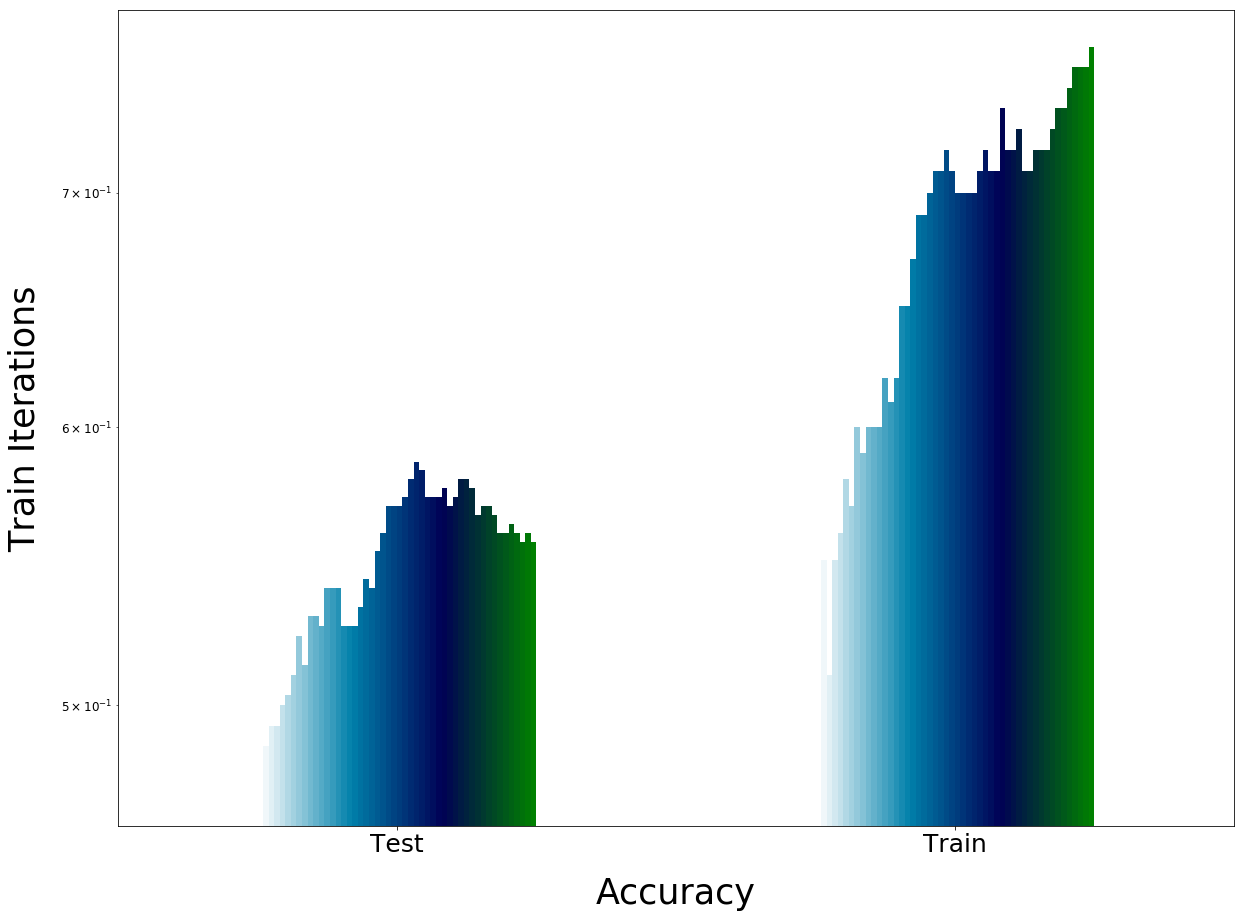

In [103]:
fig, ax = plt.subplots()
fig.patch.set_alpha(0.5)
results_df.plot(kind='bar', legend = False, figsize=(20,15), logy=True, colormap='ocean_r', ax = ax)
ax.set_axis_bgcolor('none')
ax.patch.set_alpha(0.6)

ax.set_xlabel( 'Accuracy', rotation=0, fontsize=35, labelpad=20)
ax.set_ylabel( 'Train Iterations', rotation=90, fontsize=35, labelpad=20)

for label in ax.get_xticklabels():
  label.set_rotation(0)
  label.set_size(25)
        
plt.show()

## Recurrent Neural Network 2

In [104]:
# Recurrent Neural Network 2
reset_graph()

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.002

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 25
batch_size = 50

In [105]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        print('\n  ---- Epoch ', epoch, ' ----\n')
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            print('  Batch ', iteration, ' training observations from ',  
                  iteration*batch_size, ' to ', (iteration + 1)*batch_size-1,)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print('\n  Train accuracy:', acc_train, 'Test accuracy:', acc_test)


  ---- Epoch  0  ----

  Batch  0  training observations from  0  to  49
  Batch  1  training observations from  50  to  99
  Batch  2  training observations from  100  to  149
  Batch  3  training observations from  150  to  199
  Batch  4  training observations from  200  to  249
  Batch  5  training observations from  250  to  299
  Batch  6  training observations from  300  to  349
  Batch  7  training observations from  350  to  399
  Batch  8  training observations from  400  to  449
  Batch  9  training observations from  450  to  499
  Batch  10  training observations from  500  to  549
  Batch  11  training observations from  550  to  599
  Batch  12  training observations from  600  to  649
  Batch  13  training observations from  650  to  699
  Batch  14  training observations from  700  to  749
  Batch  15  training observations from  750  to  799
  Batch  16  training observations from  800  to  849
  Batch  17  training observations from  850  to  899
  Batch  18  traini

  Batch  7  training observations from  350  to  399
  Batch  8  training observations from  400  to  449
  Batch  9  training observations from  450  to  499
  Batch  10  training observations from  500  to  549
  Batch  11  training observations from  550  to  599
  Batch  12  training observations from  600  to  649
  Batch  13  training observations from  650  to  699
  Batch  14  training observations from  700  to  749
  Batch  15  training observations from  750  to  799
  Batch  16  training observations from  800  to  849
  Batch  17  training observations from  850  to  899
  Batch  18  training observations from  900  to  949
  Batch  19  training observations from  950  to  999
  Batch  20  training observations from  1000  to  1049
  Batch  21  training observations from  1050  to  1099
  Batch  22  training observations from  1100  to  1149
  Batch  23  training observations from  1150  to  1199

  Train accuracy: 0.66 Test accuracy: 0.5366667

  ---- Epoch  7  ----

  Ba


  Train accuracy: 0.74 Test accuracy: 0.58666664

  ---- Epoch  13  ----

  Batch  0  training observations from  0  to  49
  Batch  1  training observations from  50  to  99
  Batch  2  training observations from  100  to  149
  Batch  3  training observations from  150  to  199
  Batch  4  training observations from  200  to  249
  Batch  5  training observations from  250  to  299
  Batch  6  training observations from  300  to  349
  Batch  7  training observations from  350  to  399
  Batch  8  training observations from  400  to  449
  Batch  9  training observations from  450  to  499
  Batch  10  training observations from  500  to  549
  Batch  11  training observations from  550  to  599
  Batch  12  training observations from  600  to  649
  Batch  13  training observations from  650  to  699
  Batch  14  training observations from  700  to  749
  Batch  15  training observations from  750  to  799
  Batch  16  training observations from  800  to  849
  Batch  17  training 

  Batch  3  training observations from  150  to  199
  Batch  4  training observations from  200  to  249
  Batch  5  training observations from  250  to  299
  Batch  6  training observations from  300  to  349
  Batch  7  training observations from  350  to  399
  Batch  8  training observations from  400  to  449
  Batch  9  training observations from  450  to  499
  Batch  10  training observations from  500  to  549
  Batch  11  training observations from  550  to  599
  Batch  12  training observations from  600  to  649
  Batch  13  training observations from  650  to  699
  Batch  14  training observations from  700  to  749
  Batch  15  training observations from  750  to  799
  Batch  16  training observations from  800  to  849
  Batch  17  training observations from  850  to  899
  Batch  18  training observations from  900  to  949
  Batch  19  training observations from  950  to  999
  Batch  20  training observations from  1000  to  1049
  Batch  21  training observation

In [106]:
results = {}

batch_results_raw = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            
            batch_results_raw.append( 'Batch {} training observations from {} to '.format( iteration, iteration*batch_size, (iteration + 1)*batch_size-1))

            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        results[epoch] = {'Train' : acc_train, 'Test' : acc_test}

In [107]:
results_df = pd.DataFrame.from_dict(results)

In [108]:
results_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Test,0.483333,0.496667,0.51,0.536667,0.543333,0.536667,0.536667,0.546667,0.566667,0.576667,...,0.583333,0.59,0.583333,0.58,0.583333,0.576667,0.58,0.576667,0.566667,0.57
Train,0.500000,0.580000,0.52,0.580000,0.600000,0.620000,0.660000,0.700000,0.720000,0.720000,...,0.740000,0.78,0.780000,0.80,0.800000,0.840000,0.86,0.880000,0.880000,0.90


/Users/derekhigham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  after removing the cwd from sys.path.


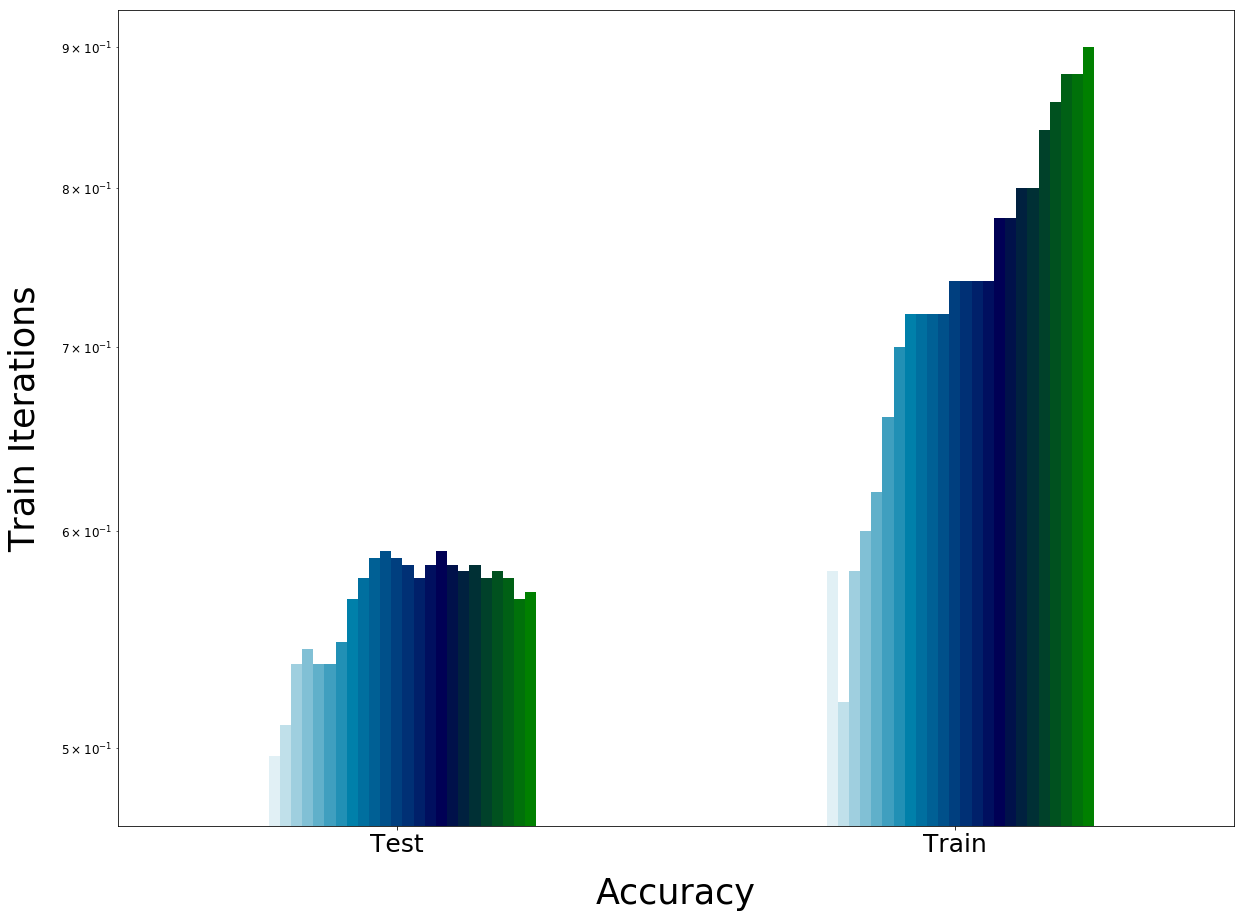

In [109]:
fig, ax = plt.subplots()
fig.patch.set_alpha(0.5)
results_df.plot(kind='bar', legend = False, figsize=(20,15), logy=True, colormap='ocean_r', ax = ax)
ax.set_axis_bgcolor('none')
ax.patch.set_alpha(0.6)

ax.set_xlabel( 'Accuracy', rotation=0, fontsize=35, labelpad=20)
ax.set_ylabel( 'Train Iterations', rotation=90, fontsize=35, labelpad=20)

for label in ax.get_xticklabels():
  label.set_rotation(0)
  label.set_size(25)
        
plt.show()